## MDTrajectory

In [2]:
import mdtraj as mdt

In [ ]:
traj = mdt.iterload("data/test.xtc", top="data/test.gro") # Generator yielding 100 frames at a time
frame = next(traj)[0]
top = frame.topology

top.select("resname =~ '4eOc'") # Indices for all atoms in 4eOc residues
top.select("name O2") # Indices for all hydroxy oxygens
top.select("type O") # Indices for all oxygens

# Some useful properties
natoms = frame.n_atoms # Number of atoms
nres = frame.n_residues # Number of residues
xyz = frame.xyz[0] # Coordinates
time = frame.time # Current time
pbc = frame.unitcell_vectors # PBC vectors
angles = frame.unitcell_angles # PBC angles
volume = frame.unitcell_volumes # System volume

array([248.59713745])

In [4]:
OH = top.select("name O2")
OE = top.select("name O12")

OH_xyz = xyz[OH]
OE_xyz = xyz[OE]

## NumPy

In [5]:
import numpy as np

Easy, fast, and simple XYZ filtering

In [6]:
xyz_filter = "(x < 1.0) & (y > 1.5)"

x, y, z = xyz.T

mask = eval(xyz_filter, {"np": np}, {"x": x, "y": y, "z": z})

xyz[mask]

array([[9.4600004e-01, 3.4720001e+00, 4.9480004e+00],
       [9.6700007e-01, 3.6280003e+00, 5.0460000e+00],
       [6.8000004e-02, 5.4080005e+00, 5.3700004e+00],
       ...,
       [9.1300005e-01, 3.3320003e+00, 6.2130003e+00],
       [8.3000004e-02, 3.9410002e+00, 5.5690002e+00],
       [5.0000004e-03, 3.6760001e+00, 5.6200004e+00]],
      shape=(3064, 3), dtype=float32)

## SciPy

In [7]:
import numpy as np
import scipy as sp

Easy, fast, and simple RDF (without normalization)

*Note that SciPy and NumPy rely on C/C++/Fortran; their libraried functions are already optimized and should be relied on as much as possible.*

In [ ]:
dmat = sp.spatial.distance_matrix(OH_xyz, OE_xyz)

distinct = False

total = dmat
intra = np.diagonal(dmat)
inter = np.zeros_like(dmat) + np.triu(dmat, k=1)

if distinct:
    inter += np.tril(dmat, k=-1)
else:
    total -= np.tril(dmat, k=-1)

rdf_total, bins = np.histogram(total, 100, (0.01, 1.01))
rdf_intra, bins = np.histogram(intra, 100, (0.01, 1.01))
rdf_inter, bins = np.histogram(inter, 100, (0.01, 1.01))

bin_centers = (bins[:-1] + bins[1:]) / 2
ideal_counts = (len(OH_xyz) / volume[0]) * 4 * np.pi * bin_centers**2 * (bins[1] - bins[0])

array([1.13735557e-04, 3.15932103e-04, 6.19226921e-04, 1.02362001e-03,
       1.52911138e-03, 2.13570101e-03, 2.84338892e-03, 3.65217511e-03,
       4.56205956e-03, 5.57304229e-03, 6.68512329e-03, 7.89830257e-03,
       9.21258011e-03, 1.06279559e-02, 1.21444300e-02, 1.37620024e-02,
       1.54806730e-02, 1.73004419e-02, 1.92213091e-02, 2.12432746e-02,
       2.33663383e-02, 2.55905003e-02, 2.79157606e-02, 3.03421191e-02,
       3.28695760e-02, 3.54981311e-02, 3.82277844e-02, 4.10585361e-02,
       4.39903860e-02, 4.70233342e-02, 5.01573806e-02, 5.33925253e-02,
       5.67287683e-02, 6.01661096e-02, 6.37045492e-02, 6.73440870e-02,
       7.10847231e-02, 7.49264575e-02, 7.88692901e-02, 8.29132210e-02,
       8.70582502e-02, 9.13043777e-02, 9.56516034e-02, 1.00099927e-01,
       1.04649350e-01, 1.09299870e-01, 1.14051489e-01, 1.18904206e-01,
       1.23858022e-01, 1.28912935e-01, 1.34068947e-01, 1.39326057e-01,
       1.44684266e-01, 1.50143572e-01, 1.55703977e-01, 1.61365481e-01,
      

In [25]:
import matplotlib.pyplot as plt

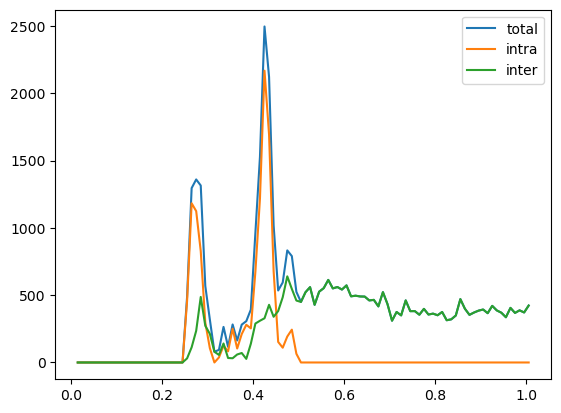

In [29]:
plt.plot(bin_centers, rdf_total / ideal_counts, label="total")
plt.plot(bin_centers, rdf_intra / ideal_counts, label="intra")
plt.plot(bin_centers, rdf_inter / ideal_counts, label="inter")

plt.legend()

## Numba

In [11]:
import time

import numba as nb


In [12]:
residue_atom_indices = []
residue_masses = []
for r in top.residues:
    atoms = np.intersect1d(top.select(f"resid {r.index}"), np.arange(top.n_atoms))
    residue_atom_indices.append(atoms.astype(np.int32))
    residue_masses.append(
        np.array([top.atom(int(i)).element.mass for i in atoms], dtype=np.float32)
    )

In [15]:
# @nb.njit
def residue_coms(xyz_frame, residue_atom_indices, residue_masses, coms):
    for i in range(len(residue_atom_indices)):
        atoms = residue_atom_indices[i]
        masses = residue_masses[i]
        if len(atoms) == 0:
            coms[i] = np.nan
            continue
        coords = xyz_frame[atoms]
        total_mass = masses.sum()
        if total_mass == 0:
            coms[i] = np.nan
            continue
        coms[i] = np.sum(coords * masses[:, None], axis=0) / total_mass

In [16]:
for chunk in traj:
    for i, frame in enumerate(chunk):
        coms = np.empty((nres, 3), dtype=np.float32)
        frame_xyz = frame.xyz[0].astype(np.float32)
        start = time.perf_counter()
        residue_coms(frame_xyz, residue_atom_indices, residue_masses, coms)
        end = time.perf_counter()
        print(f"Iteration {i}: {end - start} s")

Iteration 0: 0.030854135000026872 s
Iteration 1: 0.027254032000200823 s
Iteration 2: 0.0463714530001198 s
Iteration 3: 0.04621605400006956 s
Iteration 4: 0.03650774200013984 s
Iteration 5: 0.027993232999961037 s
Iteration 6: 0.03321383899992725 s
Iteration 7: 0.031983437000235426 s
Iteration 8: 0.018376520999936474 s
Iteration 9: 0.01679921999993894 s
Iteration 10: 0.02121492500009481 s
Iteration 11: 0.02007392300038191 s
Iteration 12: 0.019510422000166727 s
Iteration 13: 0.016978520000066055 s
Iteration 14: 0.04398465099984605 s
Iteration 15: 0.03740354399997159 s
Iteration 16: 0.025742929999978514 s
Iteration 17: 0.017492921000211936 s
Iteration 18: 0.020128524000028847 s
Iteration 19: 0.01745651999999609 s
Iteration 20: 0.016687218999777542 s
Iteration 21: 0.017366719999699853 s
Iteration 22: 0.03518754099968646 s
Iteration 23: 0.020221822999701544 s
Iteration 24: 0.02721263200010071 s
Iteration 25: 0.01727892000008069 s
Iteration 26: 0.01727601999982653 s
Iteration 27: 0.0208390210

KeyboardInterrupt: 